# 🔍 Damage Simulation Overview

This notebook analyzes and compares the **damage performance** of three adventurers—**Leonardo**, **Gagarin**, and **Dragon Girl**—under various simulated combat scenarios. Each simulation evaluates both:

* **Damage per use**  
* **Cumulative damage across 10 rounds**  

---

## ⚙️ Base Configuration


### 📌 Player Stats (Constant Across All Characters)

These reflect a typical high-end build for DPS optimization:

| Parameter             | Value      | Description                         |
| --------------------- | ---------- | ----------------------------------- |
| `P_ATK`               | 10,000,000 | Base Attack                         |
| `Strength Multiplier` | 1.15       | Based on gear/stat scaling          |
| `P_ATK_pct`           | 3000%      | Flat ATK % bonus from gear & skills |
| `P_Global_ATK_pct`    | 250%       | Global ATK boost                    |

#### 🧮 Final Attack Formula:

$$
\text{FINAL\_ATK} = P\_ATK × Strength × (1 + P\_ATK\_pct) × (1 + P\_Global\_ATK\_pct)
$$

$$
= 10{,}000{,}000 × 1.15 × (1 + 30) × (1 + 2.5) = 1,247,750,000
$$

This `FINAL_ATK` is the core stat fed into all character skill formulas.


---

## 🧪 Scenarios

2 scenarios can be updated from the base configuration. This makes it easy to compare different situations.


In [1]:
# === BASE CONFIG (used as starting point before applying any scenario overrides) ===
BASE_CONFIG = dict(
    # Core player stats
    P_ATK=10_000_000,
    P_Strength=1.15,
    P_ATK_pct=3000,
    P_Global_ATK_pct=250,

    # Damage bonuses
    # Shared modifiers
    Skill_DMG_pct=200,
    Physical_DMG_pct=0,
    Dagger_DMG_pct=35,
    Damage_pct=0, 
    Flame_DMG_pct=0,
    Final_DMG_pct=0,
    Global_DMG_pct=0,
    Global_Skill_DMG_pct=0,   # For specific setups

    # Rage override support
    Rage_ATK_coef=260, # note: other weapon specific effects are not included here

    # Bonus Weapon Coefficients
    Bonus_Dagger_Coef=0,

    # Action counts
    Num_Attacks=5,
    Num_Daggers=14,
    Num_Rage_Strikes=1,

    # Battle settings
    Use_Whisper=True,
    ENEMY_HP=3_500_000_000_000,
    MAX_HP=3_500_000_000
)

# === SCENARIOS TO COMPARE ===

SCENARIO_1 = {
    "name": "",
    "Num_Daggers": 14,
    "Bonus_Dagger_Coef": 0,
    "Dagger_DMG_pct": 35,
    "Physical_DMG_pct": 0,
    "Damage_pct": 25,
    "Global_Skill_DMG_pct": 40,
    "Global_DMG_pct": 50,
}

SCENARIO_2 = {
    "name": "",
    "Num_Daggers": 21,
    "Bonus_Dagger_Coef": 0.09,
    "Dagger_DMG_pct": 35,
    "Physical_DMG_pct": 90,
    "Num_Rage_Strikes": 3,
    "Damage_pct": 25,
    "Global_Skill_DMG_pct": 40,
    "Global_DMG_pct": 50,
}


In [2]:
import pandas as pd

def generate_scenario_name(base_scenario: dict, compare_scenario: dict) -> str:
    diffs = []
    for key in compare_scenario:
        if key == "name":
            continue
        base_val = base_scenario.get(key, None)
        val = compare_scenario[key]
        if val != base_val:
            # Shorten key names
            short_label = (
                key.replace("Num_", "")
                   .replace("_pct", "")
                   .replace("Dagger", "Dag")
                   .replace("Physical", "Phy")
                   .replace("Skill", "Skill")
                   .replace("Flame", "Flame")
                   .replace("Global", "Global")
                   .replace("Final", "Final")
                   .replace("Coef", "Coef")
                   .replace("RageStrikes", "Rage")
                   .replace("_", "")
            )
            if isinstance(val, float):
                val_str = f"{val:.2f}" if abs(val) < 1 else f"{val:.0f}"
            else:
                val_str = str(val)
            diffs.append(f"{short_label}={val_str}")
    return "Δ: " + ", ".join(diffs) if diffs else "Same"



def apply_scenario_config(base_config: dict, scenario_overrides: dict) -> dict:
    """
    Returns a new configuration dictionary with scenario overrides applied to the base config.

    Parameters:
        base_config (dict): The base configuration containing all default values.
        scenario_overrides (dict): A partial dictionary with only the parameters to override.

    Returns:
        dict: A new dictionary combining the base config and scenario overrides.
    """
    # Make a copy so the original base is not modified
    config = base_config.copy()

    # Remove 'name' key from overrides if present
    overrides = {k: v for k, v in scenario_overrides.items() if k != "name"}

    # Apply overrides
    config.update(overrides)

    return config

SCENARIO_1["name"] = generate_scenario_name({}, SCENARIO_1)
SCENARIO_2["name"] = generate_scenario_name(SCENARIO_1, SCENARIO_2)
cfg1 = apply_scenario_config(BASE_CONFIG, SCENARIO_1)
cfg2 = apply_scenario_config(BASE_CONFIG, SCENARIO_2)

In [3]:
def gagarin_damage(level: int, config: dict, target_hp: float = 3_500_000_000_000):
    DAGGER_COEF = 0.45
    P_Strength = 1.20

    FINAL_ATK = (
        config["P_ATK"]
        * P_Strength
        * (1 + config["P_ATK_pct"] / 100)
        * (1 + config["P_Global_ATK_pct"] / 100)
    )

    # Conditional global bonuses at higher levels
    total_global_skill_pct = config["Global_Skill_DMG_pct"] + config["Global_DMG_pct"]

    global_dagger_bonus = 30 if level >= 10 else 0
    global_skill_bonus = 30 + total_global_skill_pct if level >= 10 else total_global_skill_pct

    dagger_bonus_pct = config["Dagger_DMG_pct"] + config["Skill_DMG_pct"] + config["Physical_DMG_pct"] + config["Damage_pct"]
    skill_bonus_pct = config["Skill_DMG_pct"] + config["Damage_pct"]


    # === Base hit damage function ===
    def hit_damage(coef_pct, bonus_pct=0.0, global_pct=0.0, final_pct=0.0):
        base = FINAL_ATK * (coef_pct / 100)
        return base * (1 + bonus_pct / 100) * (1 + global_pct / 100) * (1 + final_pct / 100)

    # === Typed damage wrappers ===
    def rage_hit(coef_pct):
        return hit_damage(coef_pct, skill_bonus_pct, global_skill_bonus, config["Final_DMG_pct"])

    def dagger_hit(coef_pct):
        return hit_damage(coef_pct, dagger_bonus_pct, global_dagger_bonus + global_skill_bonus, config["Final_DMG_pct"])

    def missile_hit(coef_pct):
        return hit_damage(coef_pct, dagger_bonus_pct, global_dagger_bonus + global_skill_bonus, config["Final_DMG_pct"])

    def basic_hit(coef_pct):
        return hit_damage(coef_pct, 0, 0, config["Final_DMG_pct"])

    def bomb_hit(coef_pct):
        return hit_damage(coef_pct, dagger_bonus_pct, global_dagger_bonus + global_skill_bonus, config["Final_DMG_pct"])

    # === Missile Logic ===
    missile_chance = 0.65 if level >= 5 else 0.50
    missile_coef = 1.00 if level >= 2 else 0.80
    num_daggers = config["Num_Daggers"]
    bonus_dagger_coef = config["Bonus_Dagger_Coef"]

    # Expected number of each type
    expected_dagger_total = (1 - missile_chance) * num_daggers * (DAGGER_COEF + bonus_dagger_coef)
    expected_missile_total = missile_chance * num_daggers * (missile_coef + bonus_dagger_coef)

    # === Damage Calculation ===
    rage_atk = rage_hit(config["Rage_ATK_coef"]) * config["Num_Rage_Strikes"]
    daggers_dmg = dagger_hit(expected_dagger_total * 100)
    missiles_dmg = missile_hit(expected_missile_total * 100)
    basic_atk = basic_hit(100) * config["Num_Attacks"]

    # Bomb logic (trigger every 2nd turn)
    if level < 4:
        bomb = 0
    elif level >= 7:
        bomb = bomb_hit(1800 + bonus_dagger_coef) + min(FINAL_ATK * 100, target_hp * 0.10)
    else:
        bomb = bomb_hit(900 + bonus_dagger_coef)

    total = rage_atk + daggers_dmg + missiles_dmg + bomb + basic_atk

    return {
        "RageATK": rage_atk,
        "Daggers": daggers_dmg,
        "Missiles": missiles_dmg,
        "BasicATK": basic_atk,
        "Bomb": bomb,
        "Total": total
    }


def run_gagarin_scenario(scenario_dict: dict, name: str):
    cfg = apply_scenario_config(BASE_CONFIG, scenario_dict)
    skill_rows = []
    round_rows = []
    levels = [0, 2, 4, 5, 7, 10]
    rounds = 10

    for lvl in levels:
        dmg = gagarin_damage(lvl, cfg)
        dmg["Level"] = lvl
        dmg["Scenario"] = name
        dmg["Source"] = "Gagarin"
        skill_rows.append(dmg)

        total = 0
        for rnd in range(1, rounds + 1):
            round_dmg = dmg["RageATK"] + dmg["Daggers"] + dmg["Missiles"] + dmg["BasicATK"]
            if rnd > 1 and rnd % 2 == 1:
                round_dmg += dmg["Bomb"]
            total += round_dmg
            round_rows.append({
                "Round": rnd,
                "Level": lvl,
                "Scenario": name,
                "Source": "Gagarin",
                "TotalDamage": total
            })

    return pd.DataFrame(skill_rows), pd.DataFrame(round_rows)


df_gaga_skill_1, df_gaga_rounds_1 = run_gagarin_scenario(SCENARIO_1, "Scenario 1")
df_gaga_skill_2, df_gaga_rounds_2 = run_gagarin_scenario(SCENARIO_2, "Scenario 2")

df_gaga_skill = pd.concat([df_gaga_skill_1, df_gaga_skill_2], ignore_index=True)
df_gaga_rounds = pd.concat([df_gaga_rounds_1, df_gaga_rounds_2], ignore_index=True)


In [4]:
def leo_damage(level: int, config: dict, target_hp: float = 3_500_000_000_000):
    P_Strength = 1.10
    BONUS_DAGGER_COEF = config["Bonus_Dagger_Coef"]
    DAGGER_COEF = 0.45 + BONUS_DAGGER_COEF

    FINAL_ATK = (
        config["P_ATK"]
        * P_Strength
        * (1 + config["P_ATK_pct"] / 100)
        * (1 + config["P_Global_ATK_pct"] / 100)
    )

    def hit_damage(coef_pct, bonus_pct=0.0, global_pct=0.0, final_pct=0.0):
        base = FINAL_ATK * (coef_pct / 100)
        return base * (1 + bonus_pct / 100) * (1 + global_pct / 100) * (1 + final_pct / 100)

    # === Bonus Buffs by Level ===
    skill_bonus = config["Skill_DMG_pct"]
    ninjutsu_bonus = 100 if level >= 5 else 0
    phys_bonus = config["Physical_DMG_pct"] + (100 if level >= 5 else 0)

    global_skill_bonus = config["Global_DMG_pct"] + config["Global_Skill_DMG_pct"]
    global_ninjutsu_bonus = 60 if level >= 10 else 0

    total_dagger_bonus = config["Dagger_DMG_pct"] + skill_bonus + phys_bonus
    final_bonus = config["Final_DMG_pct"]

    # === Scoped Damage Functions ===
    def buffed_skill_hit(coef_pct):
        return hit_damage(
            coef_pct,
            bonus_pct=skill_bonus + ninjutsu_bonus + config["Damage_pct"],
            global_pct=global_skill_bonus + global_ninjutsu_bonus,
            final_pct=final_bonus
        )

    def basic_hit(coef_pct):
        return hit_damage(
            coef_pct,
            bonus_pct=0,
            global_pct=0,
            final_pct=final_bonus
        )

    def ninjutsu_hit(coef_pct):
        return hit_damage(
            coef_pct,
            bonus_pct=skill_bonus + ninjutsu_bonus + config["Damage_pct"],
            global_pct=global_skill_bonus + global_ninjutsu_bonus,
            final_pct=final_bonus
        )

    def dagger_hit(coef_pct):
        return hit_damage(
            coef_pct,
            bonus_pct=total_dagger_bonus + config["Damage_pct"],
            global_pct=global_skill_bonus + global_ninjutsu_bonus,
            final_pct=final_bonus
        )

    def rage_hit(coef_pct):
        return hit_damage(
            coef_pct,
            bonus_pct=skill_bonus + config["Damage_pct"],
            global_pct=global_skill_bonus,
            final_pct=final_bonus
        )

    # === Damage Components ===
    def sbs_damage():
        base = sum(basic_hit(c) for c in (30, 70, 100))
        fixed_ninjutsu = ninjutsu_hit(100)
        extra = 0
        if level >= 2:
            ninjutsu_chance = 1 - (1 - 0.7) ** 3
            extra = ninjutsu_chance * ninjutsu_hit(100)
        return base + fixed_ninjutsu + extra

    def hsd_damage():
        if level < 4:
            return 0
        coef = 400 if level >= 7 else 200
        base = 5 * buffed_skill_hit(coef)
        if level >= 7:
            hp_val = 0.02 * target_hp
            hp_cap = 20 * FINAL_ATK
            base += 5 * min(hp_val, hp_cap)
        return base

    def hsd_cd():
        return 2 if level >= 7 else 3

    def wts_damage():
        if level < 8:
            return 0
        coef = 500 if level >= 10 else 300
        return 3 * buffed_skill_hit(coef)

    def rage_damage():
        if level >= 8:
            return 0
        return rage_hit(config["Rage_ATK_coef"])

    def total_daggers():
        return config["Num_Daggers"] * dagger_hit(DAGGER_COEF * 100)

    # === Final Assembly ===
    sbs = sbs_damage()
    hsd = hsd_damage()
    wts = wts_damage()
    rage_atk = rage_damage()
    daggers = total_daggers()
    cooldown = hsd_cd()

    total = sbs * config["Num_Attacks"] + hsd + wts * config["Num_Rage_Strikes"] + daggers + rage_atk

    return {
        "SBS": sbs,
        "HSD": hsd,
        "WTS": wts,
        "RageATK": rage_atk,
        "Daggers": daggers,
        "Total": total,
        "Cooldown": cooldown
    }

def run_leo_scenario(scenario_dict: dict, name: str):
    cfg = apply_scenario_config(BASE_CONFIG, scenario_dict)
    levels = [0, 2, 4, 5, 7, 8, 10]
    skill_rows = []
    round_rows = []

    for lvl in levels:
        dmg = leo_damage(lvl, cfg)
        skill_rows.append({
            "Source": "Leonardo",
            "Scenario": name,
            "Level": lvl,
            **{k: v for k, v in dmg.items() if k != "Cooldown"}
        })

        total = 0
        for rnd in range(1, 11):
            rdmg = (
                dmg["SBS"] * cfg["Num_Attacks"]
                + dmg["WTS"]
                + dmg["Daggers"]
                + dmg["RageATK"]
            )
            if rnd % dmg["Cooldown"] == 0:
                rdmg += dmg["HSD"]
            total += rdmg
            round_rows.append({
                "Source": "Leonardo",
                "Scenario": name,
                "Level": lvl,
                "Round": rnd,
                "TotalDamage": total
            })

    return pd.DataFrame(skill_rows), pd.DataFrame(round_rows)


In [5]:
def dg_damage(level: int, config: dict, stacks: bool = True, target_hp=3_500_000_000_000):
    P_Strength = 1.20
    FINAL_ATK = (
        config["P_ATK"]
        * P_Strength
        * (1 + config["P_ATK_pct"] / 100)
        * (1 + config["P_Global_ATK_pct"] / 100)
    )

    DAGGER_COEF = 0.45 + config["Bonus_Dagger_Coef"]

    def hit_damage(coef_pct, bonus_pct=0.0, global_pct=0.0, final_pct=0.0):
        base = FINAL_ATK * (coef_pct / 100)
        return base * (1 + bonus_pct / 100) * (1 + global_pct / 100) * (1 + final_pct / 100)

    # === Define Bonus Pools ===
    skill_bonus = config["Skill_DMG_pct"]
    flame_bonus = config["Flame_DMG_pct"]
    phys_bonus = config["Physical_DMG_pct"]
    dagger_bonus = config["Dagger_DMG_pct"]

    global_skill_bonus = config["Global_DMG_pct"] + config["Global_Skill_DMG_pct"]
    global_flame_bonus = 100 if stacks and level >= 5 else 0
    final_bonus = config["Final_DMG_pct"]

    # === Individual Hit Components ===
    def basic_attack_hit():
        return hit_damage(100, 0, 0, final_bonus)

    def flame_skill_hit(coef):
        return hit_damage(coef, skill_bonus + flame_bonus + config["Damage_pct"], global_skill_bonus + global_flame_bonus, final_bonus)

    def rage_hit():
        return hit_damage(config["Rage_ATK_coef"], skill_bonus + config["Damage_pct"], global_skill_bonus, final_bonus)

    def dagger_hit():
        return hit_damage(DAGGER_COEF * 100, skill_bonus + phys_bonus + dagger_bonus + config["Damage_pct"], global_skill_bonus, final_bonus)

    def dragon_breath():
        return flame_skill_hit(180) if level >= 2 else 0

    def catastrophic_breath():
        if level < 4:
            return 0
        coef = 1200 if level >= 7 else 600
        return flame_skill_hit(coef)

    def dragons_wrath():
        if level < 8:
            return 0
        cap = 100 * FINAL_ATK
        return min(0.10 * target_hp, cap) + min(0.10 * target_hp, cap)

    # === Damage Components ===
    basic_atk = config["Num_Attacks"] * basic_attack_hit()
    basic_breath = config["Num_Attacks"] * dragon_breath()
    rage_atk = rage_hit() * config["Num_Rage_Strikes"]
    rage_breath = dragon_breath() * config["Num_Rage_Strikes"]
    daggers = config["Num_Daggers"] * dagger_hit()
    cata = catastrophic_breath()
    wrath = dragons_wrath()

    total = basic_atk + basic_breath + rage_atk + rage_breath + daggers + cata + wrath

    return {
        "BasicATK": basic_atk,
        "BasicBreath": basic_breath,
        "RageATK": rage_atk,
        "BreathFromRage": rage_breath,
        "Daggers": daggers,
        "Catastrophic": cata,
        "DragonWrath": wrath,
        "Total": total
    }

def run_dragon_girl_scenario(config: dict, scenario_label: str, stacks: bool = True):
    levels = [0, 2, 4, 5, 7, 8, 10]
    rounds = list(range(1, 16))
    skill_rows = []
    round_rows = []

    for lvl in levels:
        dmg = dg_damage(lvl, config, stacks)

        skill_rows.append({
            "Source": "DragonGirl",
            "Scenario": scenario_label,
            "Level": lvl,
            **dmg
        })

        total = 0
        for rnd in rounds:
            round_dmg = (
                dmg["BasicATK"] + dmg["BasicBreath"] +
                dmg["RageATK"] + dmg["BreathFromRage"] + dmg["Daggers"]
            )
            if lvl >= 4 and rnd % 2 == 1:
                round_dmg += dmg["Catastrophic"]
            if lvl >= 8:
                round_dmg += dmg["DragonWrath"]

            total += round_dmg
            round_rows.append({
                "Source": "DragonGirl",
                "Scenario": scenario_label,
                "Level": lvl,
                "Round": rnd,
                "TotalDamage": total
            })

    return pd.DataFrame(skill_rows), pd.DataFrame(round_rows)


In [6]:
df_gaga_skill_1, df_gaga_rounds_1 = run_gagarin_scenario(SCENARIO_1, "Scenario 1")
df_gaga_skill_2, df_gaga_rounds_2 = run_gagarin_scenario(SCENARIO_2, "Scenario 2")

df_gaga_skill = pd.concat([df_gaga_skill_1, df_gaga_skill_2], ignore_index=True)
df_gaga_rounds = pd.concat([df_gaga_rounds_1, df_gaga_rounds_2], ignore_index=True)

df_leo_skill_1, df_leo_rounds_1 = run_leo_scenario(SCENARIO_1, "Scenario 1")
df_leo_skill_2, df_leo_rounds_2 = run_leo_scenario(SCENARIO_2, "Scenario 2")

df_leo_skill = pd.concat([df_leo_skill_1, df_leo_skill_2], ignore_index=True)
df_leo_rounds = pd.concat([df_leo_rounds_1, df_leo_rounds_2], ignore_index=True)

df_dg_skill_1, df_dg_rounds_1 = run_dragon_girl_scenario(cfg1, "Scenario 1", stacks=True)
df_dg_skill_2, df_dg_rounds_2 = run_dragon_girl_scenario(cfg2, "Scenario 2", stacks=True)

df_dg_skill = pd.concat([df_dg_skill_1, df_dg_skill_2], ignore_index=True)
df_dg_rounds = pd.concat([df_dg_rounds_1, df_dg_rounds_2], ignore_index=True)

df_all_skills = pd.concat([df_leo_skill, df_gaga_skill, df_dg_skill], ignore_index=True)
df_all_rounds = pd.concat([df_leo_rounds, df_gaga_rounds, df_dg_rounds], ignore_index=True)

In [7]:
# --- Ensure numeric columns are correct
numeric_cols = ["RageATK", "Daggers", "Missiles", "Bomb", "Total"]
df_all_skills[numeric_cols] = df_all_skills[numeric_cols].apply(pd.to_numeric, errors="coerce")
df_all_rounds["TotalDamage"] = pd.to_numeric(df_all_rounds["TotalDamage"], errors="coerce")

# --- Create summary label for Dragon Girl (stacked mode clarity)
df_all_skills["StacksLabel"] = ""
if "Stacks" in df_all_skills.columns:
    dg_mask = df_all_skills["Source"] == "Dragon Girl"
    df_all_skills.loc[dg_mask, "StacksLabel"] = " - " + df_all_skills.loc[dg_mask, "Stacks"].astype(str)

# --- Unified display label for plotting
df_all_skills["Label"] = df_all_skills["Source"] + df_all_skills["StacksLabel"]

# --- Standardize level column (if not already)
df_all_skills["Level"] = df_all_skills["Level"].astype(int)
df_all_rounds["Level"] = df_all_rounds["Level"].astype(int)


In [8]:
def preprocess_skill_comparison(df_all_skills, source, scenario_1="Scenario 1", scenario_2="Scenario 2"):
    df1 = df_all_skills[
        (df_all_skills["Source"] == source) & (df_all_skills["Scenario"] == scenario_1)
    ].copy()
    df2 = df_all_skills[
        (df_all_skills["Source"] == source) & (df_all_skills["Scenario"] == scenario_2)
    ].copy()

    df_merged = pd.merge(df1, df2, on="Level", suffixes=("_1", "_2"))
    return df1, df2, df_merged

def build_percent_change_table(df_merged, damage_types=None):
    records = []
    for _, row in df_merged.iterrows():
        lvl = row["Level"]
        for dmg in damage_types:
            val1 = row[f"{dmg}_1"]
            val2 = row[f"{dmg}_2"]
            pct_diff = 100 * (val2 - val1) / val1 if val1 else None
            rel = val2 / val1 if val1 else None

            records.append({
                "Level": lvl,
                "DamageType": dmg,
                "Scenario 1": val1,
                "Scenario 2": val2,
                "Relative": rel,
                "% Increase": pct_diff
            })

    return pd.DataFrame(records)


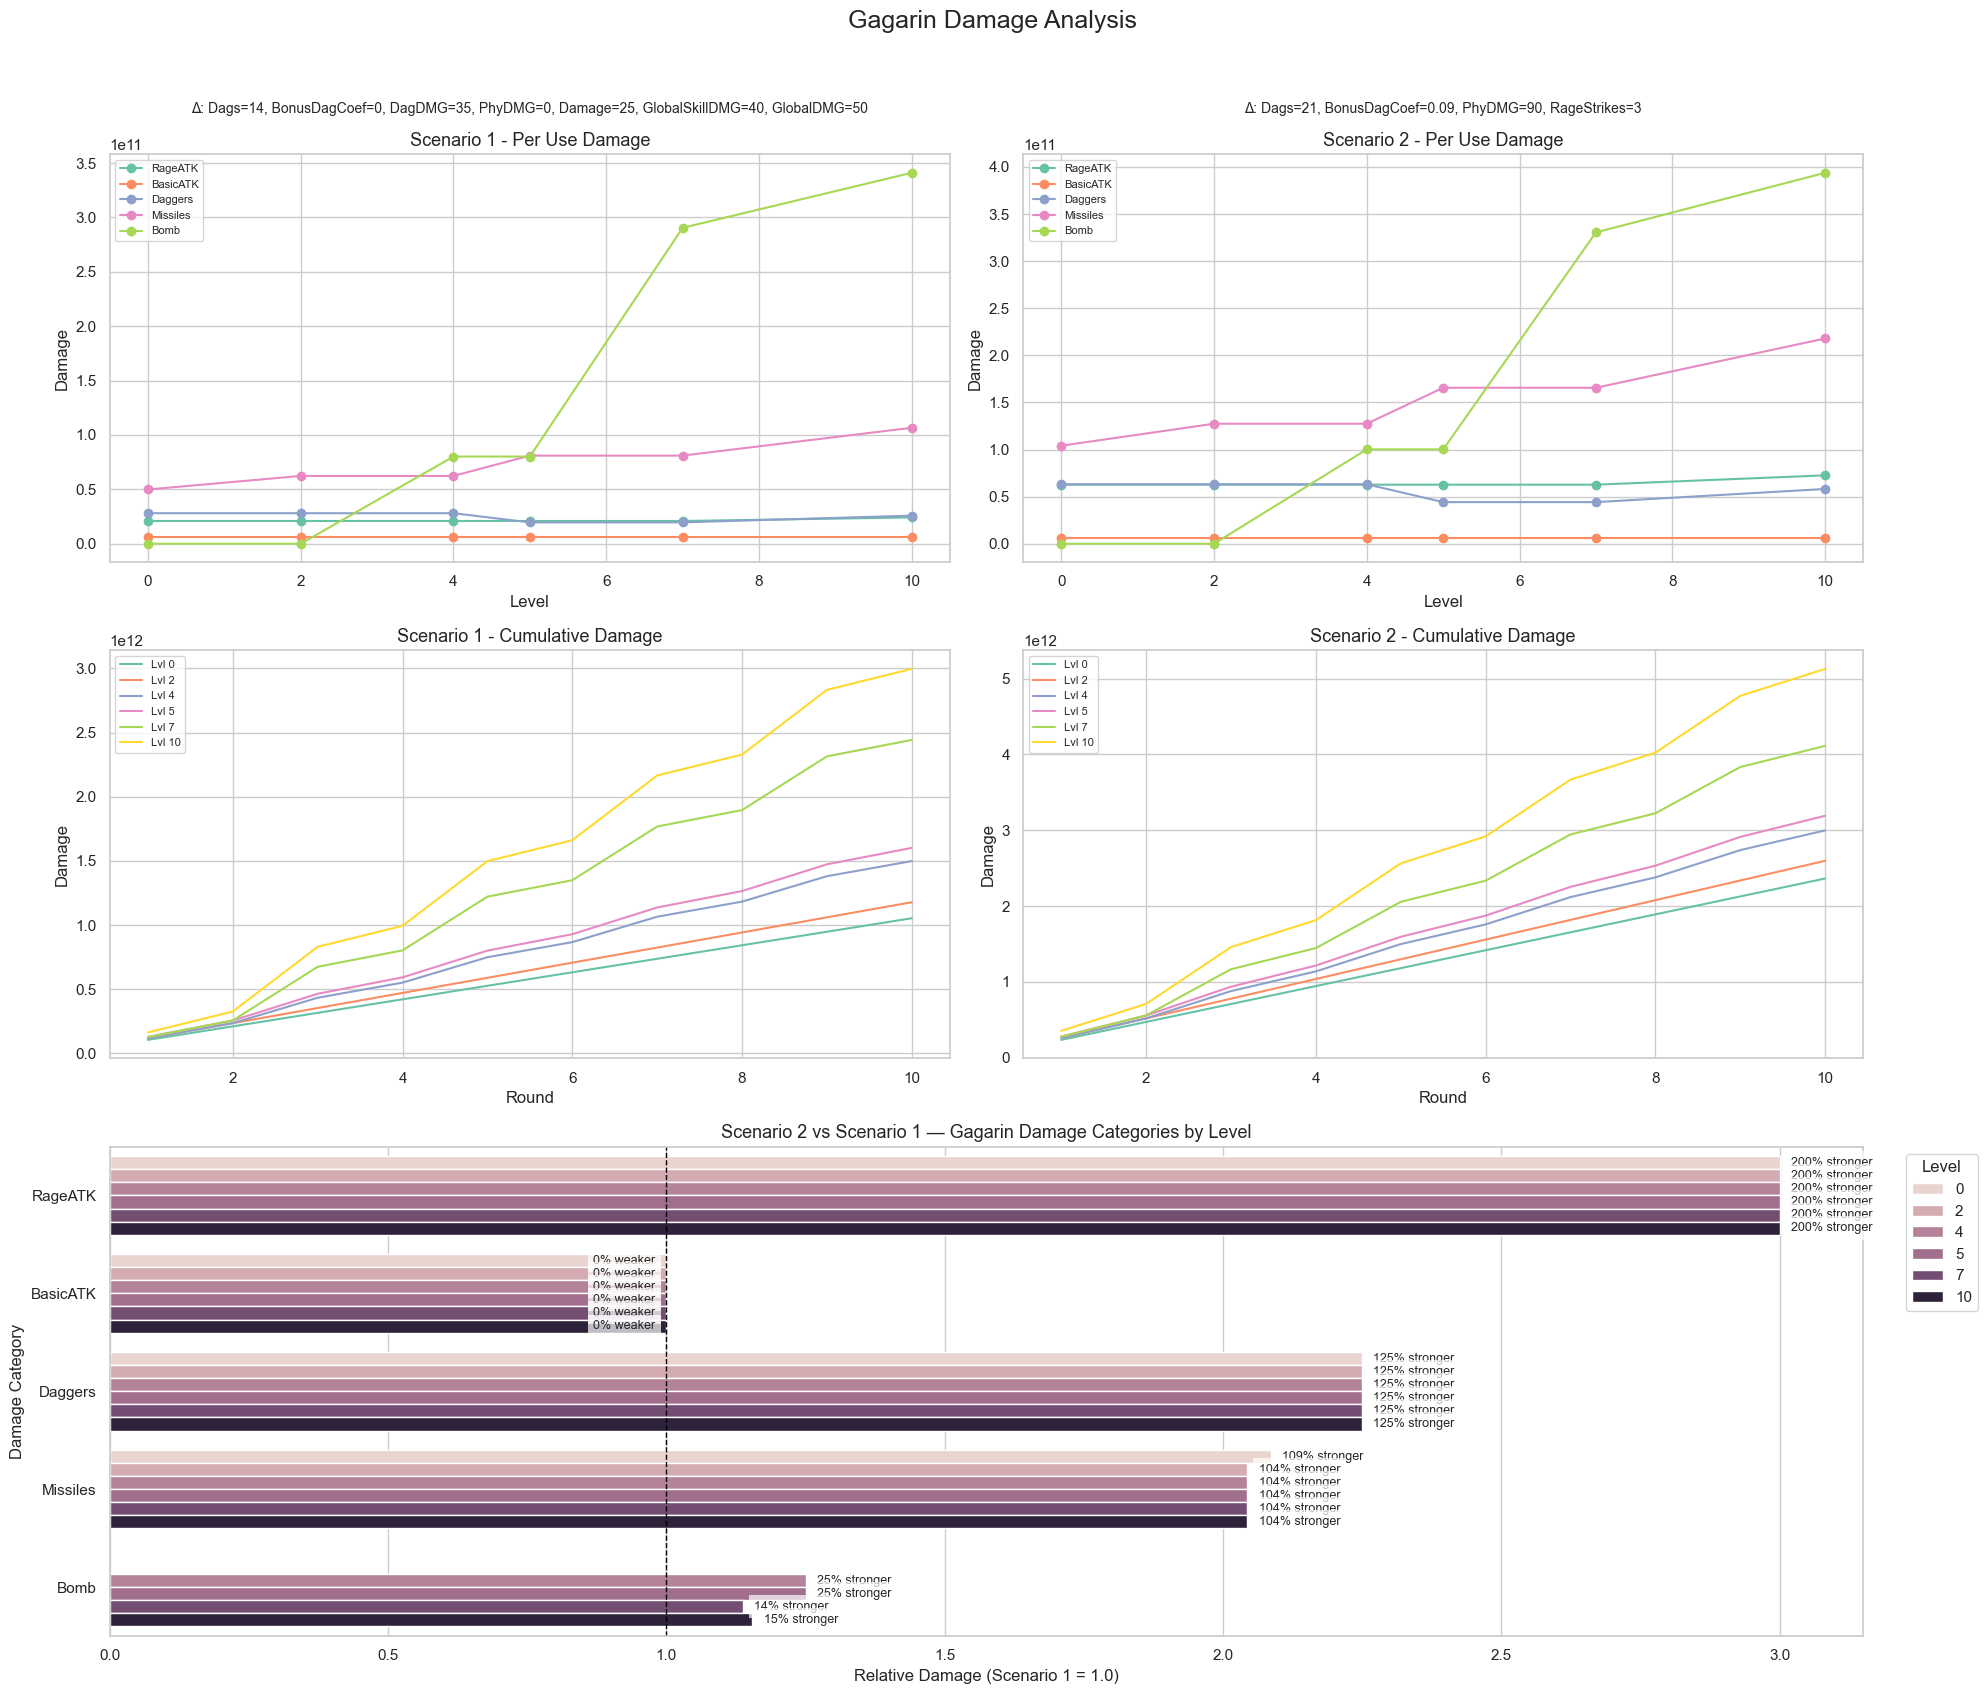

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Theme
sns.set_theme(style="whitegrid", palette="Set2")

# Map config scenario names
SCENARIO_NAME_MAP = {
    "Scenario 1": SCENARIO_1["name"],
    "Scenario 2": SCENARIO_2["name"],
}

# === Preprocess
df_g1, df_g2, df_merged_ggr = preprocess_skill_comparison(df_all_skills, "Gagarin")
df_compare_ggr = build_percent_change_table(df_merged_ggr, damage_types=["RageATK", "BasicATK", "Daggers", "Missiles", "Bomb"])

# === Create figure layout
fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])
fig.suptitle("Gagarin Damage Analysis", fontsize=18, y=0.97)

# === Row 1: Per-Use Breakdown (lineplot)
for i, (scenario, df_plot) in enumerate([("Scenario 1", df_g1), ("Scenario 2", df_g2)]):
    ax = fig.add_subplot(gs[0, i])
    df_plot.plot(
        x="Level",
        y=["RageATK", "BasicATK", "Daggers", "Missiles", "Bomb"],
        ax=ax,
        marker="o",
        title=f"{scenario} - Per Use Damage"
    )
    ax.set_title(f"{scenario} - Per Use Damage", fontsize=13)
    ax.text(0.5, 1.1, SCENARIO_NAME_MAP[scenario], fontsize=10,
            ha="center", transform=ax.transAxes)
    ax.set_xlabel("Level")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

# === Row 2: Cumulative Round Breakdown (lineplot)
for i, scenario in enumerate(["Scenario 1", "Scenario 2"]):
    ax = fig.add_subplot(gs[1, i])
    df_r = df_all_rounds[
        (df_all_rounds["Source"] == "Gagarin") & (df_all_rounds["Scenario"] == scenario)
    ]
    for lvl in df_r["Level"].unique():
        sub = df_r[df_r["Level"] == lvl]
        ax.plot(sub["Round"], sub["TotalDamage"], label=f"Lvl {lvl}")
    ax.set_title(f"{scenario} - Cumulative Damage", fontsize=13)
    ax.set_xlabel("Round")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

# === Row 3: Horizontal Barplot — Relative Damage Per Type Per Level
ax_full = fig.add_subplot(gs[2, :])  # span both columns

sns.barplot(
    data=df_compare_ggr,
    y="DamageType",
    x="Relative",
    hue="Level",
    orient="h",
    dodge=True,
    ax=ax_full
)

# Add baseline + annotations
ax_full.axvline(1.0, color="black", linestyle="--", linewidth=1)

for container in ax_full.containers:
    for bar in container:
        width = bar.get_width()
        if width == 0:
            continue
        label = f"{abs(width - 1) * 100:.0f}% {'stronger' if width > 1 else 'weaker'}"
        x = width + 0.02 if width > 1 else width - 0.02
        ax_full.text(
            x,
            bar.get_y() + bar.get_height() / 2,
            label,
            ha="left" if width > 1 else "right",
            va="center",
            fontsize=9,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )

ax_full.set_title("Scenario 2 vs Scenario 1 — Gagarin Damage Categories by Level", fontsize=13)
ax_full.set_xlabel("Relative Damage (Scenario 1 = 1.0)")
ax_full.set_ylabel("Damage Category")
ax_full.legend(title="Level", bbox_to_anchor=(1.02, 1), loc="upper left")

# Finalize layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


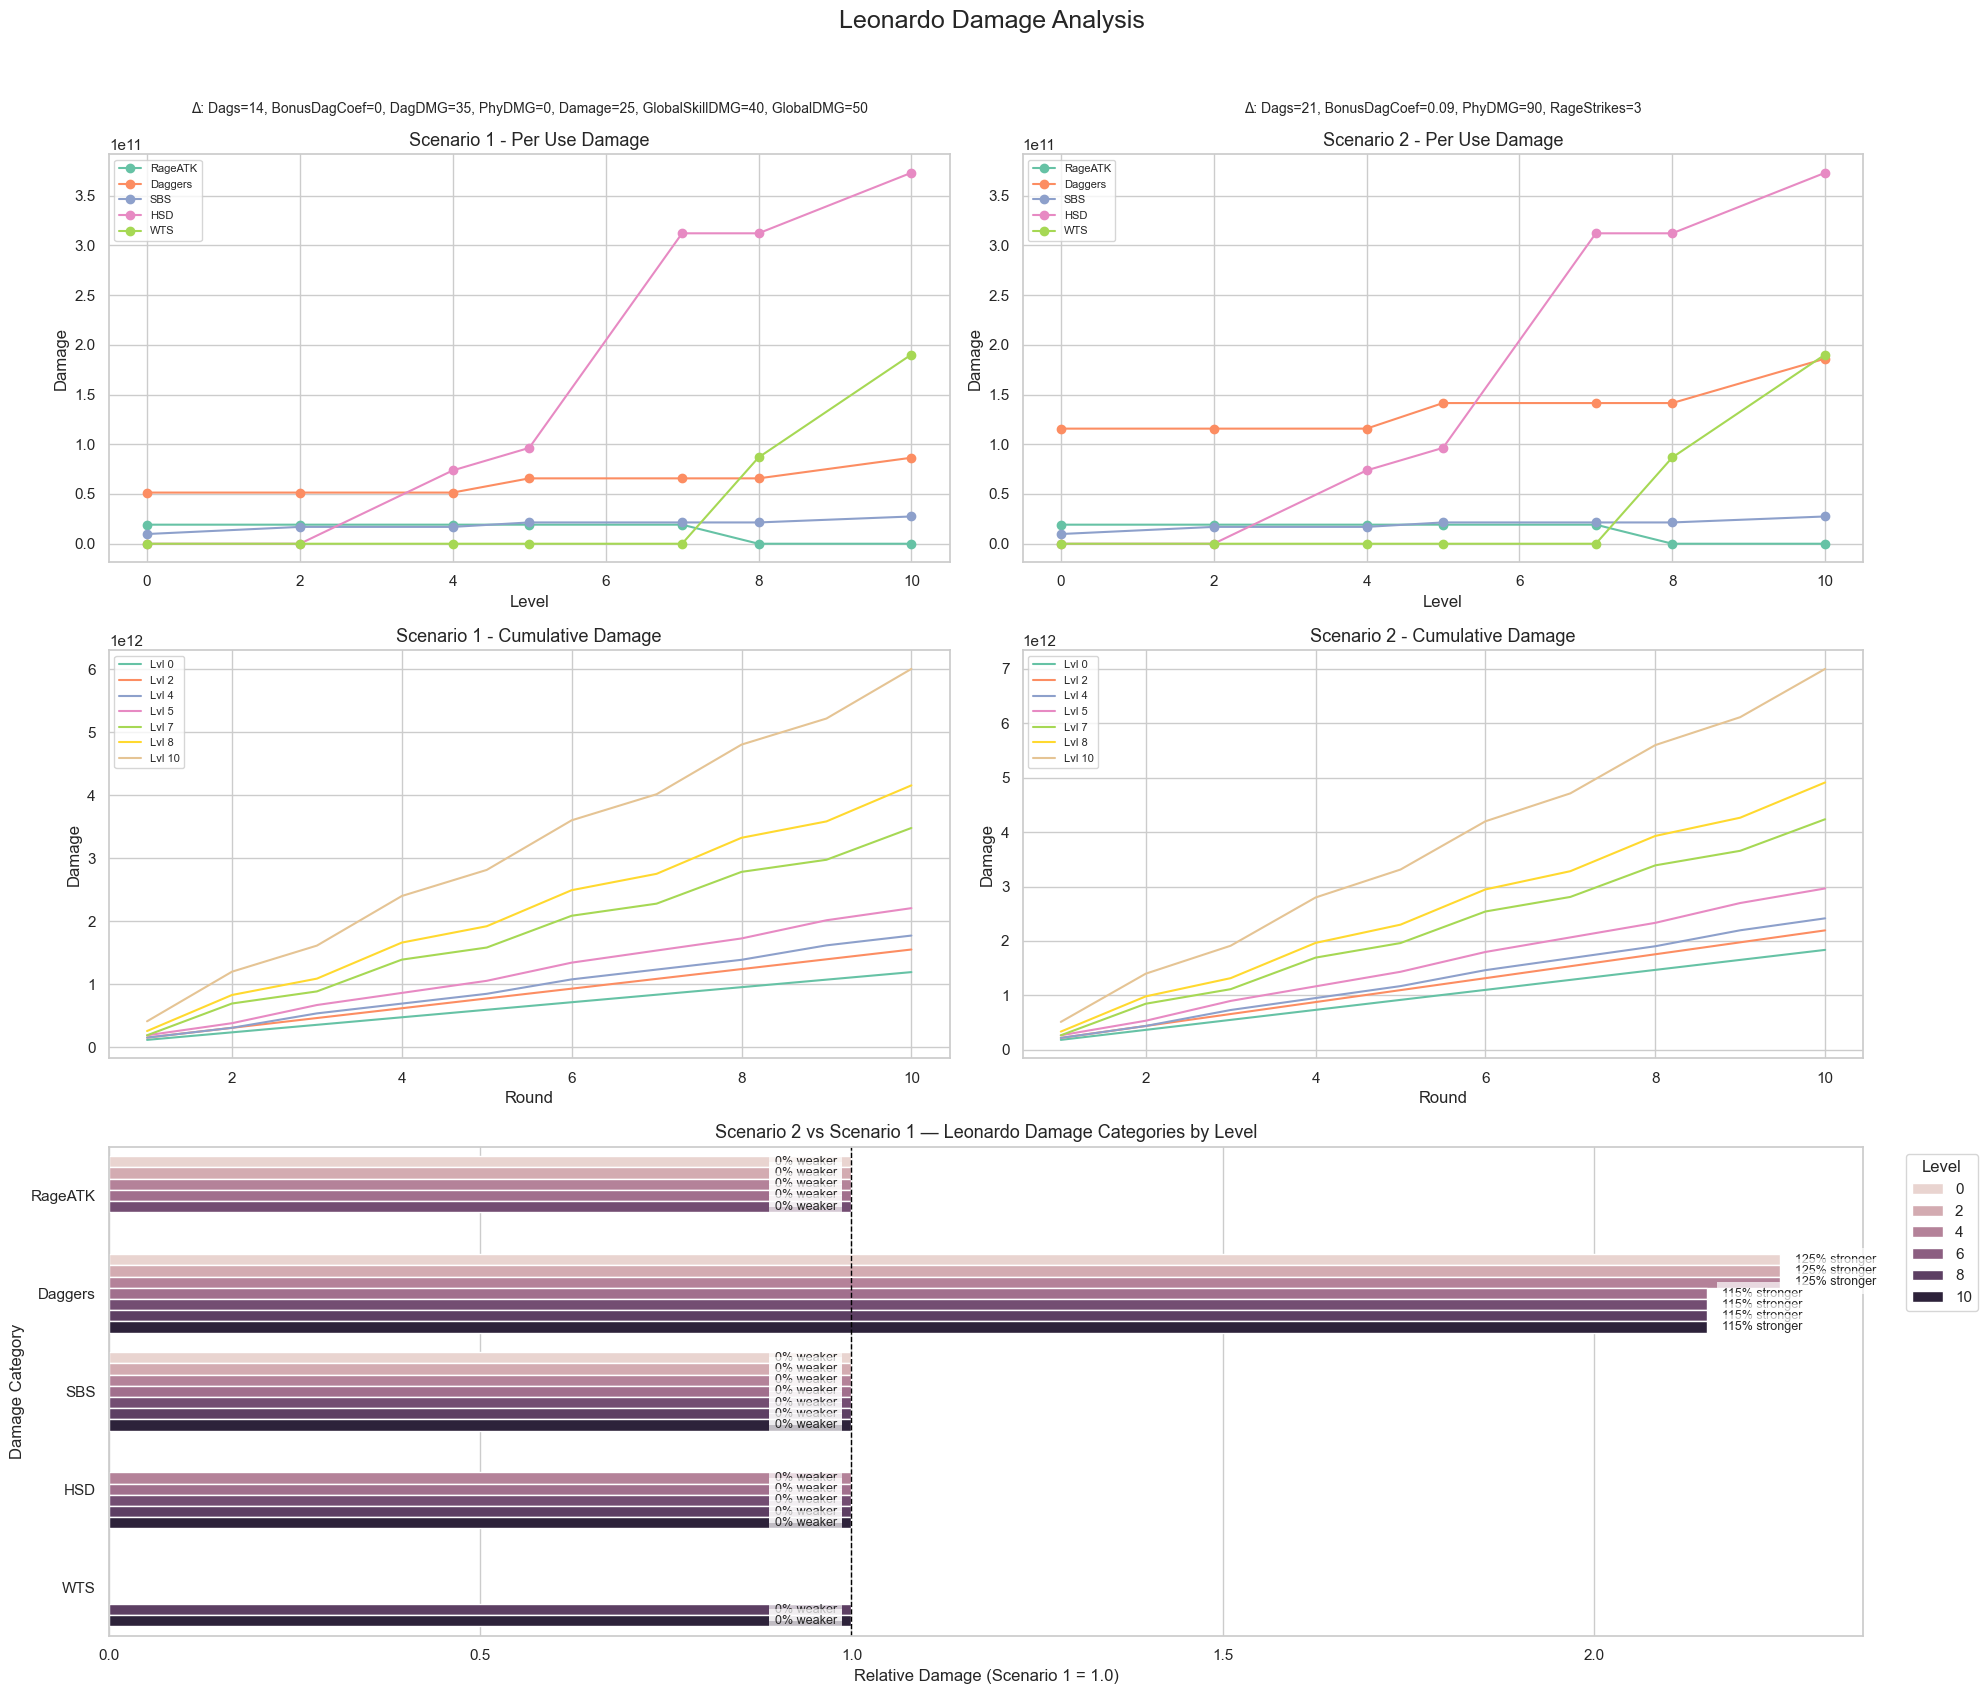

In [10]:
# === Leonardo-specific damage types
LEONARDO_DAMAGE_TYPES = ["RageATK", "Daggers", "SBS", "HSD", "WTS"]

# === Preprocess
df_l1, df_l2, df_merged_leo = preprocess_skill_comparison(
    df_all_skills, "Leonardo"
)
df_compare_leo = build_percent_change_table(
    df_merged_leo, damage_types=LEONARDO_DAMAGE_TYPES
)

# === Create figure layout
fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])
fig.suptitle("Leonardo Damage Analysis", fontsize=18, y=0.97)

# === Row 1: Per-Use Breakdown
for i, (scenario, df_plot) in enumerate([("Scenario 1", df_l1), ("Scenario 2", df_l2)]):
    ax = fig.add_subplot(gs[0, i])
    df_plot.plot(
        x="Level",
        y=LEONARDO_DAMAGE_TYPES,
        ax=ax,
        marker="o",
        title=f"{scenario} - Per Use Damage"
    )
    ax.set_title(f"{scenario} - Per Use Damage", fontsize=13)
    ax.text(0.5, 1.1, SCENARIO_NAME_MAP[scenario], fontsize=10,
            ha="center", transform=ax.transAxes)
    ax.set_xlabel("Level")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

# === Row 2: Cumulative Round Breakdown
for i, scenario in enumerate(["Scenario 1", "Scenario 2"]):
    ax = fig.add_subplot(gs[1, i])
    df_r = df_all_rounds[
        (df_all_rounds["Source"] == "Leonardo") & (df_all_rounds["Scenario"] == scenario)
    ]
    for lvl in df_r["Level"].unique():
        sub = df_r[df_r["Level"] == lvl]
        ax.plot(sub["Round"], sub["TotalDamage"], label=f"Lvl {lvl}")
    ax.set_title(f"{scenario} - Cumulative Damage", fontsize=13)
    ax.set_xlabel("Round")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

# === Row 3: Horizontal Barplot — Relative Damage Per Type Per Level
ax_full = fig.add_subplot(gs[2, :])

sns.barplot(
    data=df_compare_leo,
    y="DamageType",
    x="Relative",
    hue="Level",
    orient="h",
    dodge=True,
    ax=ax_full
)

# Add baseline and annotations
ax_full.axvline(1.0, color="black", linestyle="--", linewidth=1)

for container in ax_full.containers:
    for bar in container:
        width = bar.get_width()
        if width == 0:
            continue
        label = f"{abs(width - 1) * 100:.0f}% {'stronger' if width > 1 else 'weaker'}"
        x = width + 0.02 if width > 1 else width - 0.02
        ax_full.text(
            x,
            bar.get_y() + bar.get_height() / 2,
            label,
            ha="left" if width > 1 else "right",
            va="center",
            fontsize=9,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )

ax_full.set_title("Scenario 2 vs Scenario 1 — Leonardo Damage Categories by Level", fontsize=13)
ax_full.set_xlabel("Relative Damage (Scenario 1 = 1.0)")
ax_full.set_ylabel("Damage Category")
ax_full.legend(title="Level", bbox_to_anchor=(1.02, 1), loc="upper left")

# Final layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


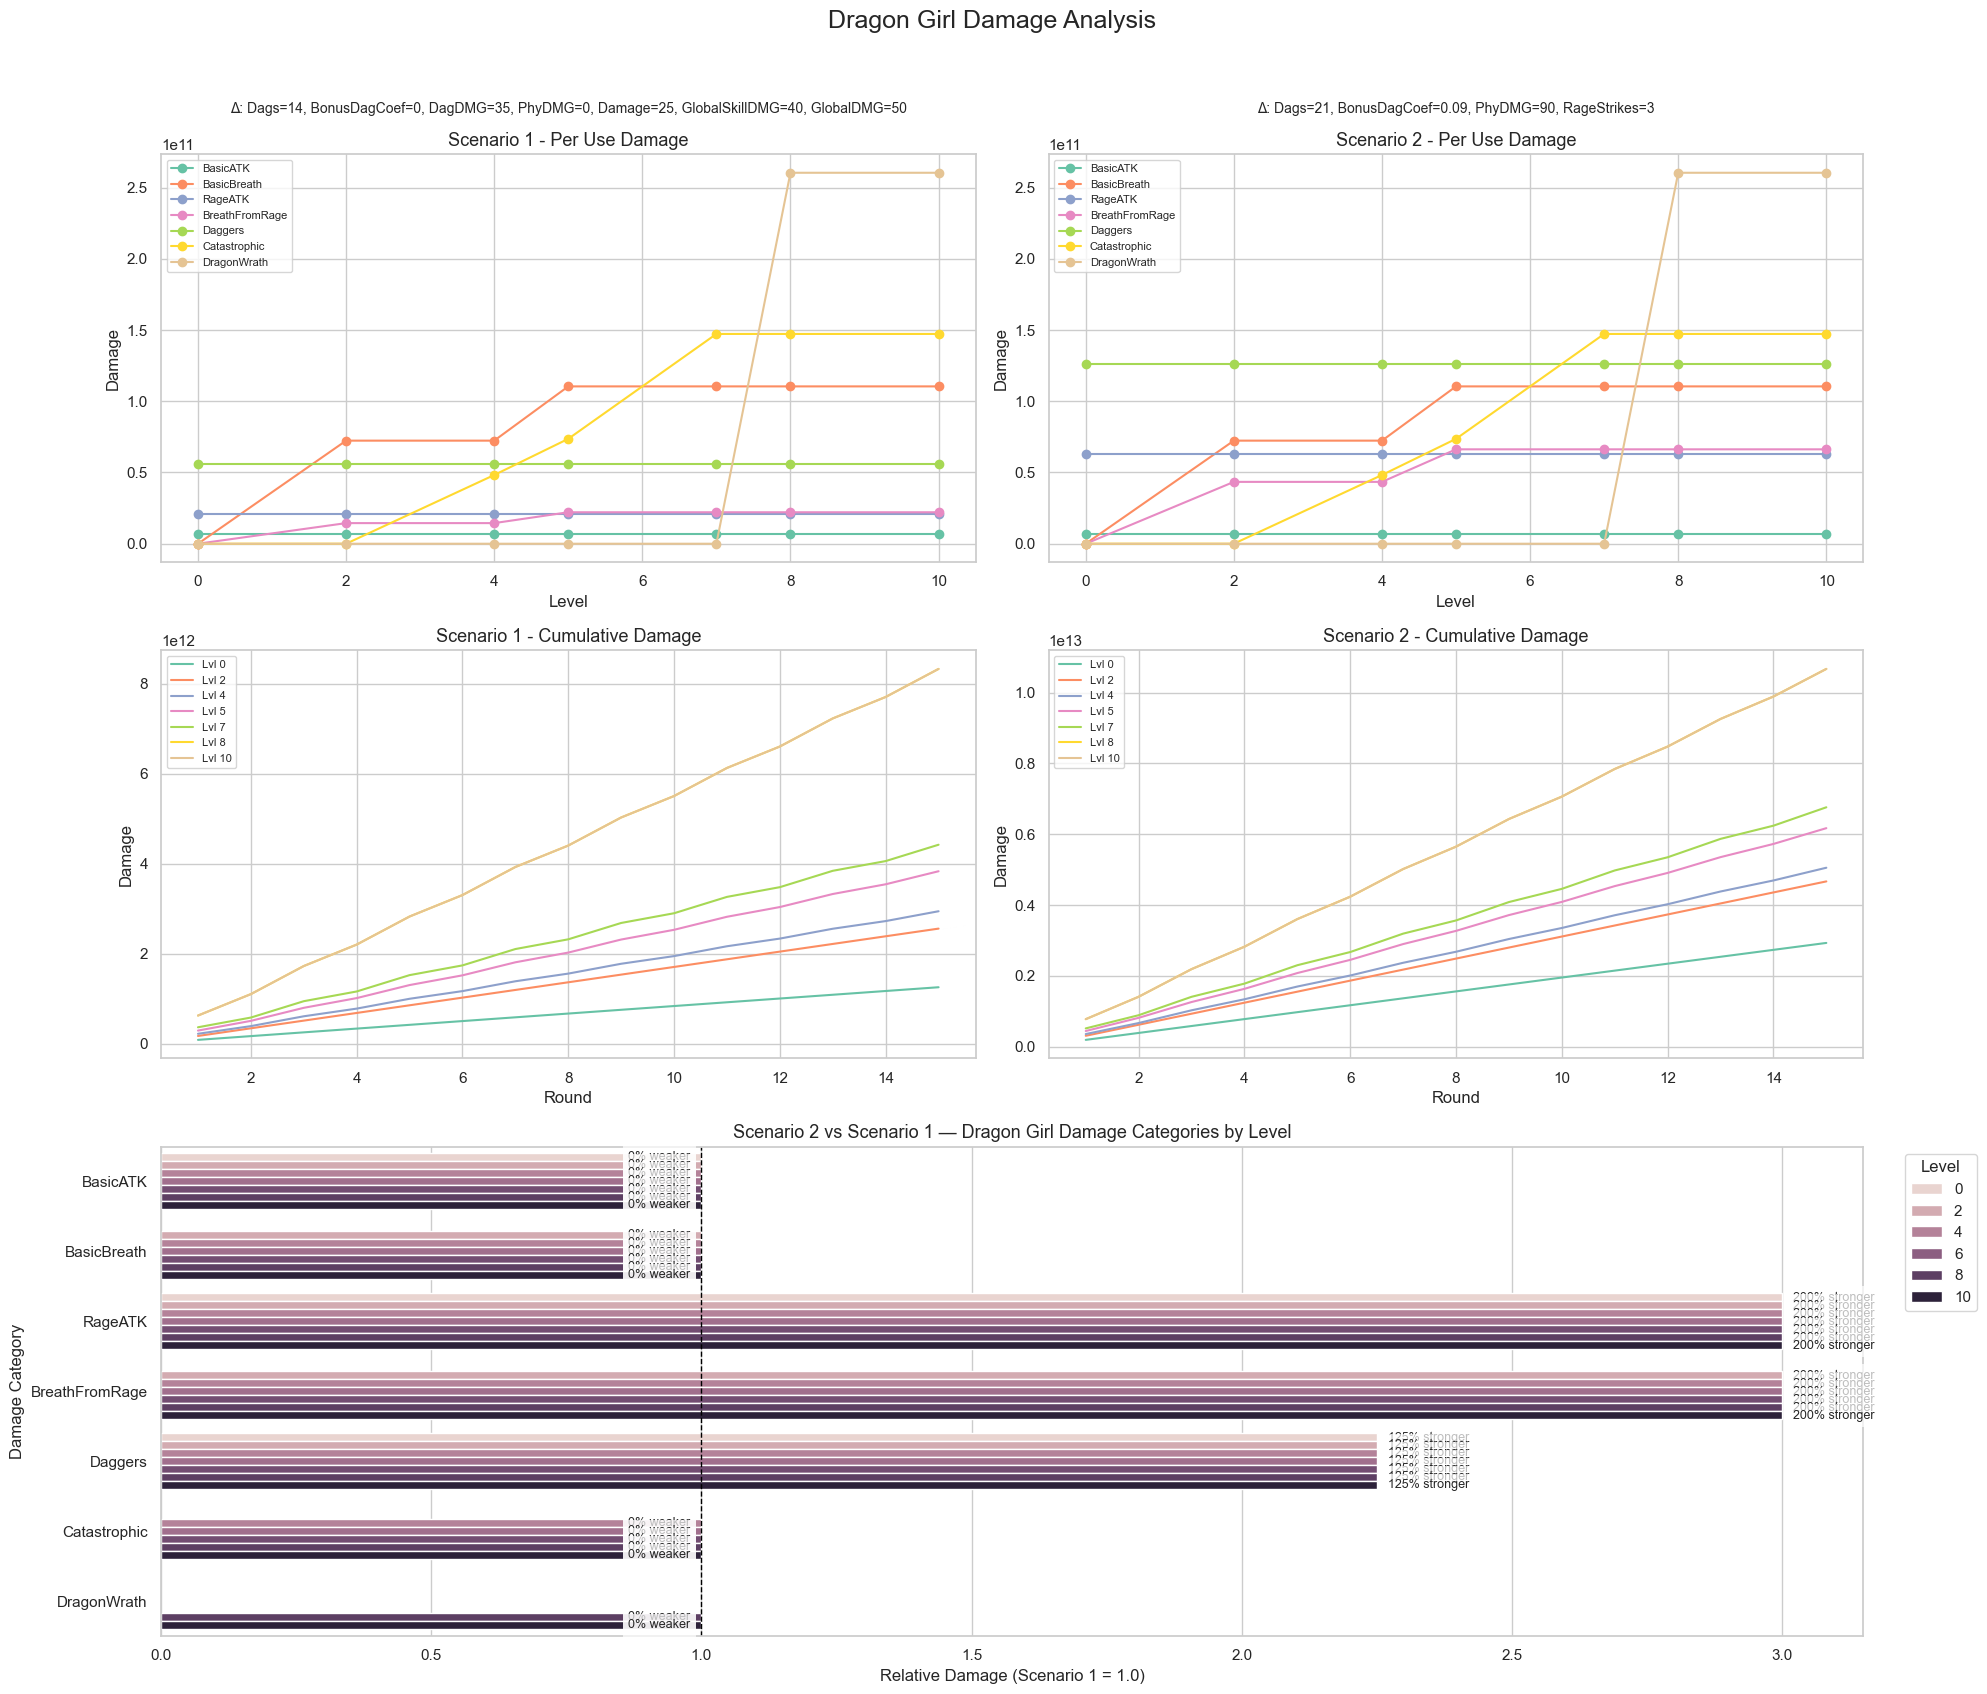

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# === Define relevant damage types
DG_DAMAGE_TYPES = [
    "BasicATK", "BasicBreath", "RageATK", "BreathFromRage",
    "Daggers", "Catastrophic", "DragonWrath"
]

# === Preprocess DG skill and round data
df_dg1, df_dg2, df_merged_dg = preprocess_skill_comparison(
    df_all_skills, "DragonGirl"
)
df_compare_dg = build_percent_change_table(
    df_merged_dg, damage_types=DG_DAMAGE_TYPES
)

# === Create layout
fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])
fig.suptitle("Dragon Girl Damage Analysis", fontsize=18, y=0.97)

# === Row 1: Per-Use Breakdown
for i, (scenario, df_plot) in enumerate([("Scenario 1", df_dg1), ("Scenario 2", df_dg2)]):
    ax = fig.add_subplot(gs[0, i])
    df_plot.plot(
        x="Level",
        y=DG_DAMAGE_TYPES,
        ax=ax,
        marker="o",
        title=f"{scenario} - Per Use Damage"
    )
    ax.set_title(f"{scenario} - Per Use Damage", fontsize=13)
    ax.text(0.5, 1.1, SCENARIO_NAME_MAP[scenario], fontsize=10,
            ha="center", transform=ax.transAxes)
    ax.set_xlabel("Level")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

# === Row 2: Cumulative Round Breakdown
for i, scenario in enumerate(["Scenario 1", "Scenario 2"]):
    ax = fig.add_subplot(gs[1, i])
    df_r = df_all_rounds[
        (df_all_rounds["Source"] == "DragonGirl") & (df_all_rounds["Scenario"] == scenario)
    ]
    for lvl in df_r["Level"].unique():
        sub = df_r[df_r["Level"] == lvl]
        ax.plot(sub["Round"], sub["TotalDamage"], label=f"Lvl {lvl}")
    ax.set_title(f"{scenario} - Cumulative Damage", fontsize=13)
    ax.set_xlabel("Round")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

# === Row 3: Relative Change in Damage by Type
ax_full = fig.add_subplot(gs[2, :])

sns.barplot(
    data=df_compare_dg,
    y="DamageType",
    x="Relative",
    hue="Level",
    orient="h",
    dodge=True,
    ax=ax_full
)

# Add baseline and annotations
ax_full.axvline(1.0, color="black", linestyle="--", linewidth=1)

for container in ax_full.containers:
    for bar in container:
        width = bar.get_width()
        if width == 0 or width is None:
            continue
        label = f"{abs(width - 1) * 100:.0f}% {'stronger' if width > 1 else 'weaker'}"
        x = width + 0.02 if width > 1 else width - 0.02
        ax_full.text(
            x,
            bar.get_y() + bar.get_height() / 2,
            label,
            ha="left" if width > 1 else "right",
            va="center",
            fontsize=9,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )

ax_full.set_title("Scenario 2 vs Scenario 1 — Dragon Girl Damage Categories by Level", fontsize=13)
ax_full.set_xlabel("Relative Damage (Scenario 1 = 1.0)")
ax_full.set_ylabel("Damage Category")
ax_full.legend(title="Level", bbox_to_anchor=(1.02, 1), loc="upper left")

# Final layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


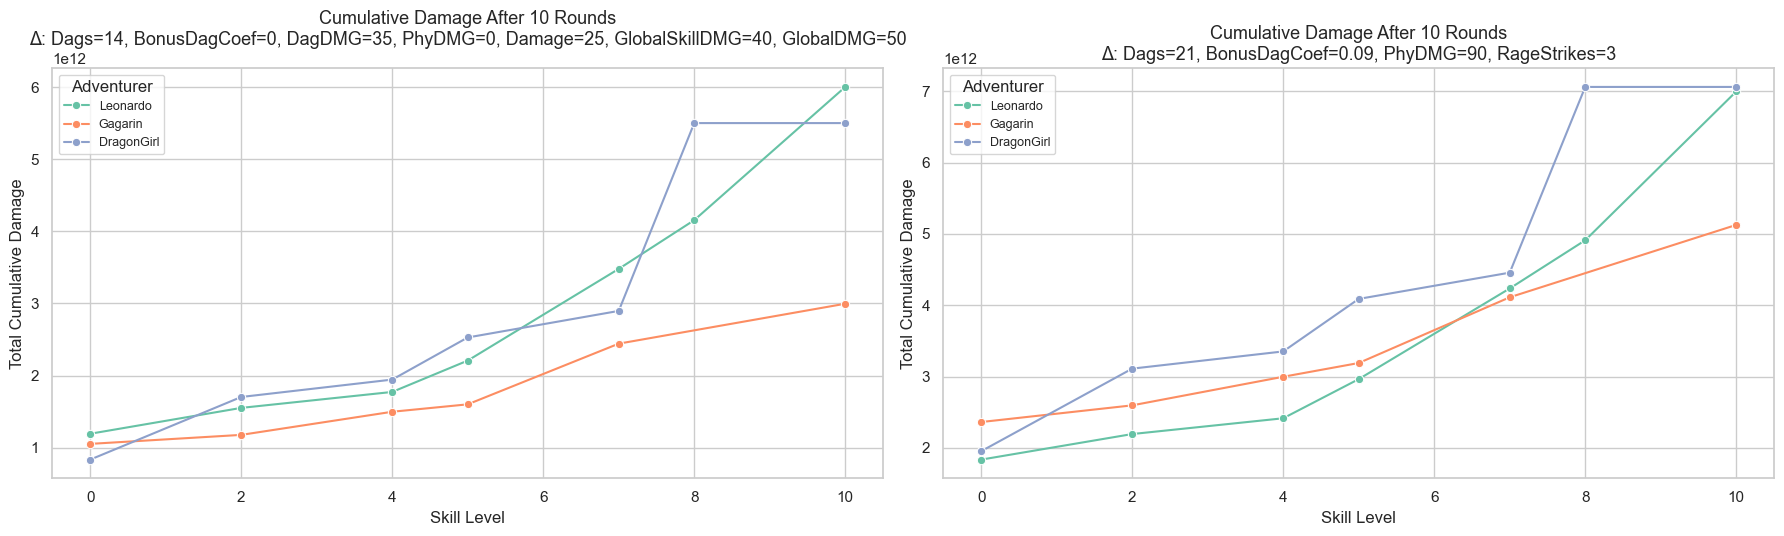

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Filter to Round 10 if not already filtered
df_final_round = df_all_rounds[df_all_rounds["Round"] == 10].copy()

# Step 2: Ensure numeric types
df_final_round["Level"] = pd.to_numeric(df_final_round["Level"], errors="coerce")
df_final_round["TotalDamage"] = pd.to_numeric(df_final_round["TotalDamage"], errors="coerce")

# Step 3: Add "StacksLabel" only for Dragon Girl
df_final_round["StacksLabel"] = ""
if "Stacks" in df_final_round.columns:
    dg_mask = df_final_round["Source"] == "Dragon Girl"
    df_final_round.loc[dg_mask, "StacksLabel"] = " - " + df_final_round.loc[dg_mask, "Stacks"].astype(str)

# Step 4: Unified label (e.g., "Dragon Girl - 20 Stacks")
df_final_round["Label"] = df_final_round["Source"] + df_final_round["StacksLabel"]

# Step 5: Create subplot grid
scenarios = df_final_round["Scenario"].unique()
fig, axs = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(9 * len(scenarios), 6))
axs = [axs] if len(scenarios) == 1 else axs.flatten()

# Step 6: Plot per scenario
for i, scenario in enumerate(scenarios):
    df_scenario = df_final_round[df_final_round["Scenario"] == scenario]
    ax = axs[i]

    sns.lineplot(
        data=df_scenario,
        x="Level",
        y="TotalDamage",
        hue="Label",
        marker="o",
        ax=ax
    )

    # Friendly name wrapping
    scenario_name = SCENARIO_NAME_MAP.get(scenario, scenario) if "SCENARIO_NAME_MAP" in globals() else scenario
    title_wrapped = f"Cumulative Damage After 10 Rounds\n{scenario_name}"
    ax.set_title(title_wrapped, fontsize=13)

    ax.set_ylabel("Total Cumulative Damage")
    ax.set_xlabel("Skill Level")
    ax.legend(title="Adventurer", fontsize=9)
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


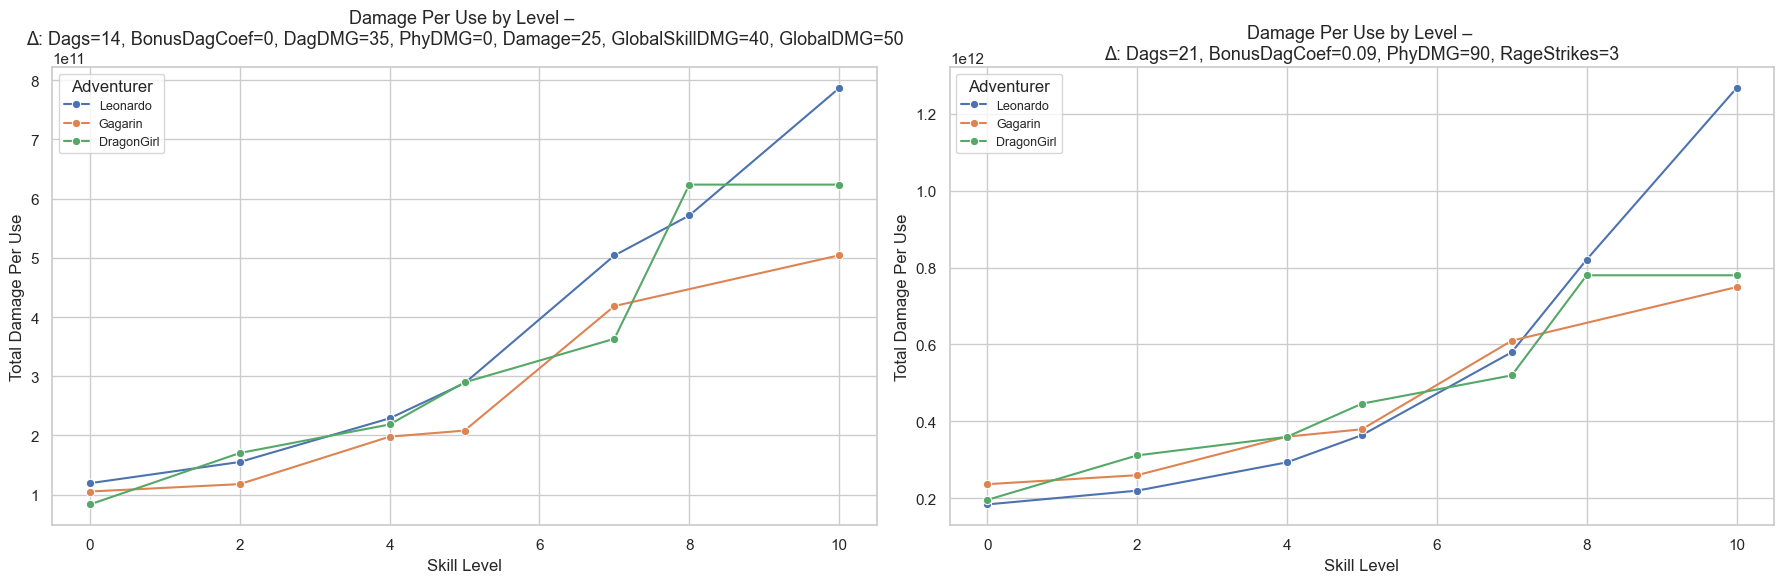

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Ensure Damage column is numeric
df_all_skills["DamagePerUse"] = pd.to_numeric(df_all_skills["Total"], errors="coerce")

# === Add "StacksLabel" for Dragon Girl clarity
df_all_skills["StacksLabel"] = ""
if "Stacks" in df_all_skills.columns:
    dg_mask = df_all_skills["Source"] == "Dragon Girl"
    df_all_skills.loc[dg_mask, "StacksLabel"] = " - " + df_all_skills.loc[dg_mask, "Stacks"].astype(str)

# === Create unified label
df_all_skills["Label"] = df_all_skills["Source"] + df_all_skills["StacksLabel"]

# === Ensure proper datatypes
df_all_skills["Level"] = pd.to_numeric(df_all_skills["Level"], errors="coerce")
df_all_skills["Scenario"] = df_all_skills["Scenario"].astype(str)

# === Plot aesthetics
sns.set(style="whitegrid")
scenarios = df_all_skills["Scenario"].unique()

# === Create subplots by scenario
fig, axs = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(18, 6))
axs = axs.flatten()

for i, scenario in enumerate(scenarios):
    ax = axs[i]
    df_scenario = df_all_skills[df_all_skills["Scenario"] == scenario]

    sns.lineplot(
        data=df_scenario,
        x="Level",
        y="DamagePerUse",
        hue="Label",
        marker="o",
        ax=ax
    )

    # Optional: scenario name map
    title = f"Damage Per Use by Level – {scenario}"
    if "SCENARIO_NAME_MAP" in globals():
        title = f"Damage Per Use by Level – \n{SCENARIO_NAME_MAP.get(scenario, scenario)}"

    ax.set_title(title, fontsize=13)
    
    ax.set_ylabel("Total Damage Per Use")
    ax.set_xlabel("Skill Level")
    ax.grid(True)
    ax.legend(title="Adventurer", fontsize=9)

plt.tight_layout()
plt.show()


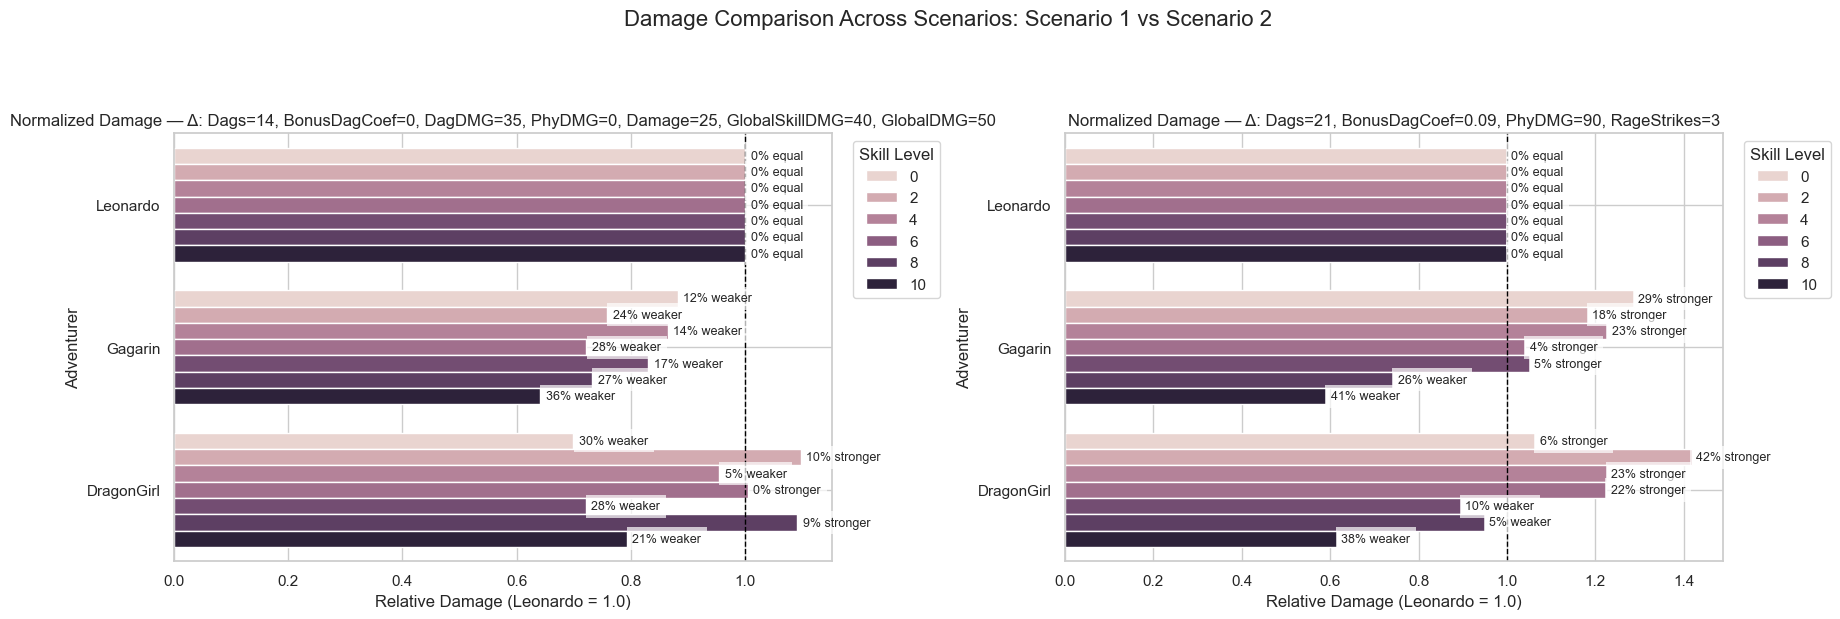

In [14]:
# Filter Gagarin level 7 data
gaga_lvl7 = df_all_skills[
    (df_all_skills["Source"] == "Gagarin") &
    (df_all_skills["Level"] == 7)
].copy()

# Duplicate and update Level to 8
gaga_lvl8 = gaga_lvl7.copy()
gaga_lvl8["Level"] = 8

# Append to main dataframe
df_all_skills = pd.concat([df_all_skills, gaga_lvl8], ignore_index=True)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric types
df_all_skills["DamagePerUse"] = pd.to_numeric(df_all_skills["Total"], errors="coerce")

# Clean adventurer label
df_all_skills["StacksLabel"] = ""
if "Stacks" in df_all_skills.columns:
    dg_mask = df_all_skills["Source"] == "Dragon Girl"
    df_all_skills.loc[dg_mask, "StacksLabel"] = " - " + df_all_skills.loc[dg_mask, "Stacks"]

df_all_skills["Label"] = df_all_skills["Source"] + df_all_skills["StacksLabel"]

# Compute baseline (Leonardo's damage) for each level + scenario
baseline = df_all_skills[df_all_skills["Source"] == "Leonardo"][["Scenario", "Level", "DamagePerUse"]]
baseline = baseline.rename(columns={"DamagePerUse": "LeonardoDamage"})

# Join to get Leonardo's damage per row
df_norm = df_all_skills.merge(baseline, on=["Scenario", "Level"], how="left")

# Compute normalized damage as a percentage of Leonardo's
df_norm["Normalized"] = df_norm["DamagePerUse"] / df_norm["LeonardoDamage"]

unique_scenarios = df_norm["Scenario"].unique()
fig, axs = plt.subplots(1, len(unique_scenarios), figsize=(9 * len(unique_scenarios), 6))

if len(unique_scenarios) == 1:
    axs = [axs]  # force into iterable if only 1 subplot

# === Global title using scenario names
scenario_text = " vs ".join(unique_scenarios)
fig.suptitle(f"Damage Comparison Across Scenarios: {scenario_text}", fontsize=16, y=1.03)

for i, scenario in enumerate(unique_scenarios):
    df_plot = df_norm[(df_norm["Scenario"] == scenario) & df_norm["Normalized"].notna()]
    ax = axs[i]

    sns.barplot(
        data=df_plot,
        y="Label",
        x="Normalized",
        hue="Level",
        orient="h",
        dodge=True,
        ax=ax
    )

    ax.axvline(1.0, color="black", linestyle="--", linewidth=1)
    ax.set_title(f"Normalized Damage — {SCENARIO_NAME_MAP.get(scenario, scenario)}")
    ax.set_xlabel("Relative Damage (Leonardo = 1.0)")
    ax.set_ylabel("Adventurer")

    # Annotate bars
    for container in ax.containers:
        for bar in container:
            width = bar.get_width()
            if pd.notna(width):
                diff_pct = (width - 1) * 100
                label = f"{abs(diff_pct):.0f}% {'stronger' if diff_pct > 0 else 'weaker' if diff_pct < 0 else 'equal'}"
                text_x = width + 0.01 if width > 0 else width - 0.01
                text_y = bar.get_y() + bar.get_height() / 2
                ax.text(
                    text_x,
                    text_y,
                    label,
                    va="center",
                    ha="left" if width > 0 else "right",
                    fontsize=9,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
                )

    ax.legend(title="Skill Level", bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.grid(True)

# Increase spacing to make room for global title
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Top margin reserved
plt.show()
